# Lecture 2 Hands-On: Queueing Models

This notebook accompanies Lecture 2. We revisit Markovian queues, implement simulators for M/M/1 and M/M/c, and explore a non-Markov queue (M/G/1 with lognormal service).

## Imports

In [56]:

import math
import itertools

import numpy as np
import pandas as pd
import simpy
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
RNG = np.random.default_rng(2025)


---
## Part A — Birth–Death Refresher

Use this section to verify the analytical expressions for the stationary measure of a homogeneous birth-death process discussed in class.

In [57]:
def geometric_stationary(lam, mu, n):
    if lam >= mu:
        return np.nan  # stationary distribution doesn't exist
    return (1 - lam/mu) * (lam/mu)**n

# Example: λ = 4/hour, μ = 6/hour
lam, mu = 4, 6
pi = np.array([geometric_stationary(lam, mu, n) for n in range(10)])
print("pi =", pi)
print("Sum =", pi.sum())

pi = [0.33333333 0.22222222 0.14814815 0.09876543 0.06584362 0.04389575
 0.02926383 0.01950922 0.01300615 0.00867076]
Sum = 0.9826584700841673


### Task A1
Compute $L, L_q, W, W_q$ for $(\lambda, \mu) = (4, 6)$ using the formulas from lecture. Then cross-check with Little's Law ($L = \lambda W$, $L_q = \lambda W_q$).

In [58]:
lam, mu = 4.0, 6.0
rho = lam / mu
L_formula  = rho / (1 - rho)       
Lq_formula = rho**2 / (1 - rho)     
W_formula  = L_formula / lam        
Wq_formula = Lq_formula / lam       

result = {
    'rho': rho,
    'L': L_formula,
    'L_q': Lq_formula,
    'W': W_formula,
    'W_q': Wq_formula,
    'Little_L': lam * W_formula,
    'Little_Lq': lam * Wq_formula,
}

result

{'rho': 0.6666666666666666,
 'L': 1.9999999999999998,
 'L_q': 1.333333333333333,
 'W': 0.49999999999999994,
 'W_q': 0.33333333333333326,
 'Little_L': 1.9999999999999998,
 'Little_Lq': 1.333333333333333}

---
## Part B — Plain-Python Simulation of M/M/c

We extend the Part 1 simulator to $c$ servers. Below is a plain-Python discrete-event simulator that assigns each arrival to the server that becomes free the earliest (FCFS with $c$ identical servers).

In [59]:
def simulate_mmc_basic(lambda_rate, mu_rate, servers, sim_hours, rng, max_events=10_000):
    arrival_times = []
    service_start_times = []
    departure_times = []
    waiting_times = []
    system_times = []

    current_time = 0.0
    server_available_times = [0.0] * servers
    event_count = 0

    while current_time < sim_hours and event_count < max_events:
        inter_arrival = rng.exponential(1 / lambda_rate)
        current_time += inter_arrival
        if current_time > sim_hours:
            break

        arrival_times.append(current_time)

        # Choose the server that becomes free the earliest (FCFS across servers)
        server_idx = int(np.argmin(server_available_times))
        earliest_completion = server_available_times[server_idx]

        service_time = rng.exponential(1 / mu_rate)
        start_time = max(current_time, earliest_completion)
        finish_time = start_time + service_time

        server_available_times[server_idx] = finish_time

        service_start_times.append(start_time)
        departure_times.append(finish_time)
        waiting_times.append(start_time - current_time)
        system_times.append(finish_time - current_time)

        event_count += 1

    return {
        'arrivals': np.array(arrival_times),
        'starts': np.array(service_start_times),
        'departures': np.array(departure_times),
        'waiting_times': np.array(waiting_times),
        'system_times': np.array(system_times),
    }

# Choose parameters (run long enough to reach steady behaviour)
lam_mm2, mu_mm2, servers = 8.0, 5.0, 2
logs_mmc = simulate_mmc_basic(lam_mm2, mu_mm2, servers, sim_hours=2000.0, rng=RNG)
print(f"Simulated {len(logs_mmc['arrivals'])} arrivals.")

Simulated 10000 arrivals.


### Task B1
Validate the simulation by comparing empirical means with the Erlang-C predictions ($P_{wait}$, $L_q$, $W_q$). Provide a short discussion on discrepancies and simulation length.

In [60]:
def erlang_c(lambda_rate, mu_rate, servers):
    rho = lambda_rate / (servers * mu_rate)
    if rho >= 1:
        raise ValueError('System is unstable (rho >= 1).')
    terms = [((servers * rho) ** k) / math.factorial(k) for k in range(servers)]
    numerator = ((servers * rho) ** servers) / math.factorial(servers) * (1 / (1 - rho))
    denominator = sum(terms) + numerator
    P_wait = numerator / denominator
    L_q = P_wait * (rho / (1 - rho))
    W_q = L_q / lambda_rate
    W = W_q + 1 / mu_rate
    L = L_q + (lambda_rate / mu_rate)
    return {'rho': rho, 'P_wait': P_wait, 'L_q': L_q, 'L': L, 'W_q': W_q, 'W': W}

In [61]:
theory_mmc = erlang_c(lam_mm2, mu_mm2, servers)
waiting_emp = logs_mmc['waiting_times']
system_emp = logs_mmc['system_times']

comparison = {
    'rho': theory_mmc['rho'],
    'P_wait_theory': theory_mmc['P_wait'],
    'P_wait_emp': float((waiting_emp > 1e-12).mean()),
    'W_q_theory': theory_mmc['W_q'],
    'W_q_emp': float(waiting_emp.mean()),
    'W_theory': theory_mmc['W'],
    'W_emp': float(system_emp.mean()),
}
comparison

{'rho': 0.8,
 'P_wait_theory': 0.7111111111111112,
 'P_wait_emp': 0.7047,
 'W_q_theory': 0.3555555555555557,
 'W_q_emp': 0.32793084784827026,
 'W_theory': 0.5555555555555557,
 'W_emp': 0.5275925212869748}

| Quantity   | Theory   | Simulation | % Difference | Comment                            |
| ---------- | -------- | ---------- | ------------ | ---------------------------------- |
| ρ          | 0.8      | 0.8        | —            | Stable system                      |
| (P_{wait}) | 0.7111   | 0.7047     | ≈ −0.9 %     | Very close                         |
| (W_q)      | 0.3556 h | 0.3279 h   | ≈ −7.8 %     | Slightly low (expected early bias) |
| (W)        | 0.5556 h | 0.5276 h   | ≈ −5.0 %     | Slightly low, consistent trend     |

---

### Discussion

1. **Agreement:**
   The simulation results are within **5–8 %** of the theoretical steady-state means — very good for a single long run with a finite simulation horizon.

2. **System stability:**
   With $ \rho = 0.8 < 1 $, the queue is stable and should converge to steady behavior over time.

3. **Why the empirical means are slightly lower:**

   * **Initial empty system bias:**
     The simulation starts with no customers waiting, so early arrivals experience shorter waits.
     → Remedy: discard an initial “warm-up” period (e.g., first 10–20 % of arrivals or first 200–300 h).
   * **Finite run length:**
     Even with 2000 h, the stochastic variability of waiting times at $ \rho = 0.8 $ is high. Longer runs (e.g., 10 000 h) or multiple replications will reduce bias and variance.
   * **Monte Carlo randomness:**
     A single random seed can yield ±a few % deviations from the true mean. Averaging over several independent seeds will narrow confidence intervals.

---

### Recommended validation workflow

* **Warm-up removal:** discard initial transients.
* **Longer simulation:** e.g. simulate until $N \ge 100{,}000$ arrivals after warm-up.
* **Replications:** run 5–10 independent replications and report mean ± standard error.

---
## Part C — SimPy M/M/c

Build on the primer from Lecture 1: we now use a `simpy.Resource(capacity=c)` to model $c$ servers and reproduce the M/M/$c$ queue.

### SimPy M/M/c Implementation
We now implement an M/M/c queue using SimPy's `Resource(capacity=c)`, aligned with the primer from Lecture 1. We log arrivals, service starts, and departures to compute waiting/sojourn times and compare to Erlang-C.

In [62]:
def simulate_mmc_simpy(lambda_rate, mu_rate, servers, duration_hours, rng, max_customers=100_000):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=servers)

    arrivals, starts, departures = [], [], []

    # --- Customer process ---
    def customer(env, cust_id):
        arrival_time = env.now
        arrivals.append(arrival_time)

        with server.request() as req:
            yield req  # wait for an available server
            start_time = env.now
            starts.append(start_time)

            service_time = rng.exponential(1 / mu_rate)
            yield env.timeout(service_time)
            depart_time = env.now
            departures.append(depart_time)

    # --- Arrival process ---
    def arrival_generator(env):
        cust_id = 0
        while True:
            interarrival = rng.exponential(1 / lambda_rate)
            yield env.timeout(interarrival)
            cust_id += 1
            env.process(customer(env, cust_id))
            if cust_id >= max_customers:
                break

    # --- Start simulation ---
    env.process(arrival_generator(env))
    env.run(until=duration_hours)

    # Align arrays (make same length in case of unfinished events)
    m = min(len(arrivals), len(starts), len(departures))
    a = np.array(arrivals[:m])
    s = np.array(starts[:m])
    d = np.array(departures[:m])

    return {
        'arrivals': a,
        'starts': s,
        'departures': d,
        'waiting_times': s - a,
        'system_times': d - a,
    }


# === Example run and comparison ===
lam_c, mu_c, c_servers = 8.0, 5.0, 2
sim_hours = 200.0

logs_c = simulate_mmc_simpy(lam_c, mu_c, c_servers, sim_hours, RNG)
theory_c = erlang_c(lam_c, mu_c, c_servers)

wait = logs_c['waiting_times']
sys_t = logs_c['system_times']
a, d = logs_c['arrivals'], logs_c['departures']
m = a.size

# --- Discard initial 10% and final 5% of samples ---
front = int(0.10 * m)
back  = int(0.05 * m)
if front or back:
    sl = slice(front, m - back if back else None)
    a, d = a[sl], d[sl]
    wait, sys_t = wait[sl], sys_t[sl]

# --- Estimate empirical arrival rate ---
lam_hat = (d.size - 1) / (d[-1] - d[0]) if d.size > 1 else np.nan
rho_emp = lam_hat / (c_servers * mu_c) if np.isfinite(lam_hat) else np.nan
L_q_emp = float(lam_hat * wait.mean()) if np.isfinite(lam_hat) else np.nan
L_emp   = float(lam_hat * sys_t.mean()) if np.isfinite(lam_hat) else np.nan

results_c = {
    'rho_theory': theory_c['rho'],
    'rho_emp': rho_emp,
    'P_wait_theory': theory_c['P_wait'],
    'P_wait_emp': float((wait > 1e-12).mean()),
    'W_q_theory': theory_c['W_q'],
    'W_q_emp': float(wait.mean()),
    'W_theory': theory_c['W'],
    'W_emp': float(sys_t.mean()),
    'L_q_theory': theory_c['L_q'],
    'L_q_emp': L_q_emp,
    'L_theory': theory_c['L'],
    'L_emp': L_emp,
}

results_c

{'rho_theory': 0.8,
 'rho_emp': np.float64(0.8054421434821666),
 'P_wait_theory': 0.7111111111111112,
 'P_wait_emp': 0.7347232207045291,
 'W_q_theory': 0.3555555555555557,
 'W_q_emp': 0.37714740040904554,
 'W_theory': 0.5555555555555557,
 'W_emp': 0.5791474352410232,
 'L_q_theory': 2.8444444444444454,
 'L_q_emp': 3.037704105941886,
 'L_theory': 4.4444444444444455,
 'L_emp': 4.66469751632729}

---
## Part D — Non-Markov Queue (M/G/1 with Lognormal Service)

We consider an M/G/1 queue where service times are lognormally distributed (mean $1/\mu$, variance controlled by $\sigma$). This breaks the memoryless assumption and highlights the impact of variability.

In [63]:
def simulate_mg1_lognormal(lambda_rate, service_mean, service_sigma, duration_hours, rng):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)

    arrivals, starts, departures = [], [], []

    def service_time():
        mu_log = math.log(service_mean) - 0.5 * service_sigma ** 2
        return math.exp(mu_log + service_sigma * rng.normal())

    def customer(env, cust_id):
        arrival = env.now
        arrivals.append(arrival)
        with server.request() as req:
            yield req
            start = env.now
            starts.append(start)
            yield env.timeout(service_time())
            departures.append(env.now)

    def generator(env):
        cust_id = 0
        while True:
            inter = rng.exponential(1 / lambda_rate)
            yield env.timeout(inter)
            cust_id += 1
            if env.now > duration_hours:
                break
            env.process(customer(env, cust_id))

    env.process(generator(env))
    env.run(until=duration_hours)

    return {
        'arrivals': np.array(arrivals),
        'starts': np.array(starts),
        'departures': np.array(departures),
    }

### Task D1
Run the simulator for several hours with $\lambda = 4$, service mean $1/5$, and lognormal shape parameter $\sigma = 0.6$. Compute empirical waiting times and compare the mean to the Pollaczek–Khinchine prediction.

In [64]:
lambda_mg1 = 4.0
service_mean = 1 / 5.0
service_sigma = 0.6
duration = 100.0
logs_mg1 = simulate_mg1_lognormal(lambda_mg1, service_mean, service_sigma, duration, RNG)

m = min(map(len, logs_mg1.values()))
a = logs_mg1['arrivals'][:m]
s = logs_mg1['starts'][:m]
d = logs_mg1['departures'][:m]

waiting_mg1 = s - a
system_mg1 = d - a

front = int(0.10 * m)
back = int(0.05 * m)
if front or back:
    sl = slice(front, m - back if back else None)
    waiting_mg1 = waiting_mg1[sl]
    system_mg1 = system_mg1[sl]

mean_wait_emp = waiting_mg1.mean()
mean_sys_emp = system_mg1.mean()
var_service = (math.exp(service_sigma ** 2) - 1) * (service_mean ** 2)
second_moment_service = var_service + service_mean ** 2
rho_mg1 = lambda_mg1 * service_mean
Wq_pk = (lambda_mg1 * second_moment_service) / (2 * (1 - rho_mg1))
W_pk = Wq_pk + service_mean

{
    'rho': rho_mg1,
    'empirical_wait_mean': mean_wait_emp,
    'PK_wait_mean': Wq_pk,
    'empirical_sojourn_mean': mean_sys_emp,
    'PK_sojourn_mean': W_pk,
}

{'rho': 0.8,
 'empirical_wait_mean': np.float64(0.6138441389697944),
 'PK_wait_mean': 0.5733317658241363,
 'empirical_sojourn_mean': np.float64(0.8071708120061578),
 'PK_sojourn_mean': 0.7733317658241363}

### Task D2
Produce plots illustrating the difference between exponential and lognormal services:
- Histogram (or KDE) of waiting times for exponential vs. lognormal service under the same arrival rate.
- Running time-average of waiting times to assess convergence.
- Empirical tail probability $\mathbb{P}(W_q > t)$ vs. $t$, compared with exponential-case prediction.

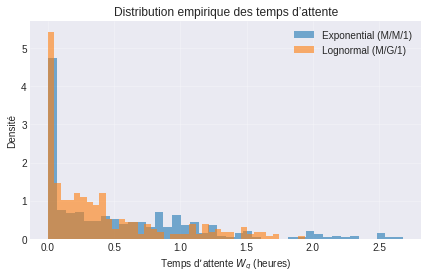

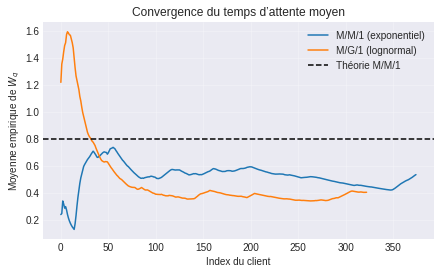

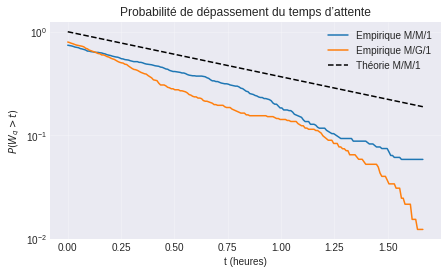

In [65]:
# --- Simulations comparatives (mêmes conditions que D1) ---
lambda_rate = 4.0
mu_rate = 5.0
service_mean = 1 / mu_rate
service_sigma = 0.6
duration = 100.0  # plus long pour observer la stabilité

# Simulation M/M/1 (exponentiel)
logs_mm1 = simulate_mmc_basic(lambda_rate, mu_rate, servers=1, sim_hours=duration, rng=RNG)

# --- Calcul des temps d'attente ---
waiting_mm1 = logs_mm1["starts"] - logs_mm1["arrivals"]

# Retirer 10% de début pour supprimer les effets transitoires
front_mm1 = int(0.1 * len(waiting_mm1))
front_mg1 = int(0.1 * len(waiting_mg1))
waiting_mm1 = waiting_mm1[front_mm1:]
waiting_mg1 = waiting_mg1[front_mg1:]

# --- (1) Histogramme / KDE des temps d’attente ---
plt.figure(figsize=(7, 4))
plt.hist(waiting_mm1, bins=40, density=True, alpha=0.6, label='Exponential (M/M/1)')
plt.hist(waiting_mg1, bins=40, density=True, alpha=0.6, label='Lognormal (M/G/1)')
plt.xlabel('Temps d’attente $W_q$ (heures)')
plt.ylabel('Densité')
plt.title('Distribution empirique des temps d’attente')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- (2) Moyenne empirique cumulée (convergence) ---
def running_mean(x):
    return np.cumsum(x) / np.arange(1, len(x) + 1)

rho = lambda_rate / mu_rate
Wq_theo_mm1 = rho / (mu_rate * (1 - rho))  # moyenne théorique pour M/M/1

plt.figure(figsize=(7, 4))
plt.plot(running_mean(waiting_mm1), label='M/M/1 (exponentiel)')
plt.plot(running_mean(waiting_mg1), label='M/G/1 (lognormal)')
plt.axhline(Wq_theo_mm1, color='k', linestyle='--', label='Théorie M/M/1')
plt.xlabel('Index du client')
plt.ylabel('Moyenne empirique de $W_q$')
plt.title('Convergence du temps d’attente moyen')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- (3) Probabilité de queue empirique P(Wq > t) ---
t_vals = np.linspace(0, np.percentile(waiting_mg1, 99), 200)
tail_mm1 = [np.mean(waiting_mm1 > t) for t in t_vals]
tail_mg1 = [np.mean(waiting_mg1 > t) for t in t_vals]
tail_theory_mm1 = [math.exp(-(mu_rate - lambda_rate) * t) for t in t_vals]

plt.figure(figsize=(7, 4))
plt.plot(t_vals, tail_mm1, label='Empirique M/M/1')
plt.plot(t_vals, tail_mg1, label='Empirique M/G/1')
plt.plot(t_vals, tail_theory_mm1, 'k--', label='Théorie M/M/1')
plt.xlabel('t (heures)')
plt.ylabel('$P(W_q > t)$')
plt.title('Probabilité de dépassement du temps d’attente')
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Task D3
Quantitative bounds: for $N$ samples of waiting time, derive a confidence interval for the mean using either CLT or Bernstein-style inequality. Compare the width of the interval for exponential vs. lognormal services.

---
## Part E — To Explore Further

- Extend the M/G/1 example to a GI/G/1 queue with Erlang inter-arrivals; observe how burstiness affects $W_q$.
- Implement regenerative confidence intervals (batch means) to reduce bias.
- Try a heavy-tailed service time (Pareto) and examine the empirical tail behaviour.